

Import Python packages and PacBio sequencing data analysis softwares, [alignparse](https://jbloomlab.github.io/alignparse/) and [dms_variants](https://jbloomlab.github.io/dms_variants/)

### Table of Contents
    Setup
    PacBio amplicons
    CCS stats for PacBio runs
    Align CCSs to amplicons
    Write valid CCSs

In [1]:
%matplotlib inline

import os
import re
import time
import math
import warnings
import collections

import matplotlib.pyplot as plt
import numpy as np


import alignparse 
import alignparse.ccs
import alignparse.targets
import alignparse.minimap2
import alignparse.consensus
from alignparse.constants import CBPALETTE


import dms_variants
import dms_variants.utils
import dms_variants.plotnine_themes
import dms_variants.codonvarianttable

import pandas as pd
import numpy
import yaml


from IPython.display import display, HTML
from plotnine import *

from Bio.Seq import Seq


warnings.simplefilter('ignore')

Set plotnine theme

In [2]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

Versions of key softwares:

In [3]:
print(f"Using alignparse version {alignparse.__version__}")
print(f"Using dms_variants version {dms_variants.__version__}")

Using alignparse version 0.6.3
Using dms_variants version 1.6.0


Read the configuration file:

In [4]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Make output directory for figures:

In [5]:
os.makedirs(config['figs_dir'], exist_ok=True)
os.makedirs(config['process_ccs_dir'], exist_ok=True)

# PacBio amplicons

Get the amplicon sequenced by PacBio as the alignment target along with the specs on how to parse the features:

In [6]:
print(f"Reading amplicons from {config['amplicons']}")
print(f"Reading feature parse specs from {config['feature_parse_specs']}")

targets = alignparse.targets.Targets(
        seqsfile=config['amplicons'],
        feature_parse_specs=config['feature_parse_specs'])

Reading amplicons from input_files/PacBio_amplicon.gb
Reading feature parse specs from input_files/insr_feature_parse_specs.yaml


Draw the target amplicon:

Saving plot to results/figures/amplicon.pdf


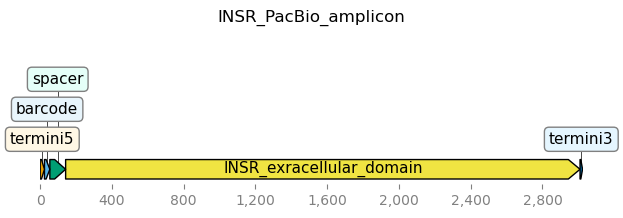

In [7]:
fig = targets.plot(ax_width=7,
                   plots_indexing='biopython',  # numbering starts at 0
                   ax_height=2,  # height of each plot
                   hspace=1.2,  # vertical space between plots
                   )

plotfile = os.path.join(config['figs_dir'], 'amplicon.pdf')
print(f"Saving plot to {plotfile}")
fig.savefig(plotfile, bbox_inches='tight')

Write out the specs used to parse the features

In [8]:
#feature parse_specs updated and the analysis run again, see
# insr_feature_parse_specs_updatedYML.yaml in input folder, there was not difference in 
# resulted codon variant table. 
print(targets.feature_parse_specs('yaml'))

INSR_PacBio_amplicon:
  query_clip5: 4
  query_clip3: 4
  termini5:
    filter:
      clip5: 4
      mutation_nt_count: 1
      mutation_op_count: null
      clip3: 0
    return: []
  INSR_exracellular_domain:
    filter:
      mutation_nt_count: 30
      mutation_op_count: null
      clip5: 0
      clip3: 0
    return:
    - mutations
    - accuracy
  spacer:
    filter:
      mutation_nt_count: 1
      mutation_op_count: null
      clip5: 0
      clip3: 0
    return: []
  barcode:
    return:
    - sequence
    - accuracy
    filter:
      clip5: 0
      clip3: 0
      mutation_nt_count: 0
      mutation_op_count: 0
  termini3:
    filter:
      clip3: 4
      mutation_nt_count: 1
      mutation_op_count: null
      clip5: 0
    return: []



# Align CCS reads to the amplicon

Read data frame with information on PacBio run and display:

In [9]:
pacbio_runs = pd.read_csv(config['pacbio_runs'], dtype=str)
fastq=pacbio_runs['fastq']

print ("Reading amplicons from: " + (pacbio_runs['fastq'][0]))
print ("Reading ccs report from: " + pacbio_runs['report'][0])

Reading amplicons from: input_files/m64069_210129_194725.hifi_reads.fastq
Reading ccs report from: input_files/ccs.report.txt



Initialise alignparse.minimap2.Mapper to align the reads:

In [10]:
mapper = alignparse.minimap2.Mapper(alignparse.minimap2.OPTIONS_CODON_DMS)

print(
    f"Using `minimap2` {mapper.version} with these options:\n"
    + " ".join(mapper.options)
)

ValueError: Can't execute `prog` minimap2. Is it installed?

Create and parse the alignments

In [ ]:
readstats, aligned, filtered = targets.align_and_parse(
        df=pacbio_runs,
        mapper=mapper,
        outdir=config['process_ccs_dir'],
        name_col='run',
        group_cols=['name', 'library'],
        queryfile_col='fastq',
        overwrite=True,
        ncpus=config['max_cpus'],
        )

load alignments files

In [11]:
aligned_=pd.read_csv(config['aligned_CCSs'], keep_default_na=False)
filtered_=pd.read_csv(config['filtered_CCSs'], keep_default_na=False)

aligned=aligned_
aligned['library']='insr'
aligned['name']='insr'
aligned['run']='first' 
aligned['target']='INSR_PacBio_amplicon'

aligned=aligned[['name','library','run','query_name', 'query_clip5', 'query_clip3', 'gene_mutations',
       'gene_accuracy', 'barcode_sequence', 'barcode_accuracy','target']]

filtered=filtered_.groupby(['filter_reason']).size().reset_index(name='count').sort_values(['count'], ascending=False)
filtered['library']='insr'
filtered['name']='insr'
filtered['run']='first'
filtered['target']='INSR_PacBio_amplicon'




d = {'name': 'insr', 'library':'insr', 'run': 'first', 'category':['aligned IR_Pb_amplicon', 'filtered IR_Pb_amplicon','unmapped'], 'count':[3568566,309112,139229] }
readstats = pd.DataFrame(data=d)

Summary statistics table and plot for the alignment

In [12]:
display(HTML(readstats.to_html(index=False)))


p = (
    ggplot(readstats, aes('category', 'count')) +
    geom_bar(stat='identity') +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(1.5 * len(pacbio_runs), 2.5),
          panel_grid_major_x=element_blank()  # no vertical grid lines
          )
    )

p.draw()

plotfile = os.path.join(config['figs_dir'], 'readstats.pdf')
print(f"Saving plot to {plotfile}")
ggsave(p,plotfile)

name,library,run,category,count
insr,insr,first,aligned IR_Pb_amplicon,3568566
insr,insr,first,filtered IR_Pb_amplicon,309112
insr,insr,first,unmapped,139229


Saving plot to results/figures/readstats.pdf


Reorder filter dataframe by count for plotting


In [13]:
filter_reason_list = filtered['filter_reason'].value_counts().index.tolist()
filter_reason_cat = pd.Categorical(filtered['filter_reason'], categories=filter_reason_list)
filtered = filtered.assign(filter_reason_cat = filter_reason_cat)

plot the filtering reason for all runs:

In [14]:
ncol = 1
nrow=1

nreasons = filtered['filter_reason'].nunique()

p = (
    ggplot(filtered, aes('filter_reason_cat', 'count')) +
    geom_bar(stat='identity') +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(0.25 * nreasons, 2),
          panel_grid_major_x=element_blank(),
          )
    )

print(p)

<ggplot: (250 x 200)>


Read parsed alignments into a data frame and save as processed CCSs

In [15]:
aligned_df = (aligned.drop(columns=['query_clip5', 'query_clip3', 'run','name'])
              .rename(columns={'barcode_sequence': 'barcode'}))

print(f"First few lines of information on the parsed alignments:")
display(HTML(aligned_df.head().to_html(index=False)))

aligned_df.to_csv(config['processed_ccs_file'], index=False)

print("\nBarcodes and mutations for valid processed CCSs "
      f"have been written to {config['processed_ccs_file']}.")

First few lines of information on the parsed alignments:


library,query_name,gene_mutations,gene_accuracy,barcode,barcode_accuracy,target
insr,m64069_210129_194725/0/ccs,,1.000000,TTGCATGGACTTCATCATGTCCTGTAGCGG,1.0,INSR_PacBio_amplicon
insr,m64069_210129_194725/2623639/ccs,T886A G888C,0.999998,ATTGTTAACAGCTAACATATCGCCGTACTA,1.0,INSR_PacBio_amplicon
insr,m64069_210129_194725/5376327/ccs,A2191C G2193C,0.999999,TTGGCCATTGCTCTCGTACGCTCTCTTGAC,1.0,INSR_PacBio_amplicon
insr,m64069_210129_194725/8258771/ccs,ins20G ins573G A892C ins1050G ins1561C,0.999469,GGTTTCTAGCAAAACATGCGTGCGGAATAT,1.0,INSR_PacBio_amplicon
insr,m64069_210129_194725/11077867/ccs,G683T C684G,0.999930,TCGGGAACCCCACGTTTCCTCTGCGGTAAA,1.0,INSR_PacBio_amplicon



Barcodes and mutations for valid processed CCSs have been written to results/process_ccs/processed_ccs.csv.


# Get processed CCSs

Read the processed CCSs into a data frame:

In [16]:
processed_ccs = pd.read_csv(config['processed_ccs_file'], na_filter=None)

print(f"Loaded {len(processed_ccs)} CCSs, here are the first few lines:.")

display(HTML(processed_ccs.head().to_html(index=False)))

Loaded 3568566 CCSs, here are the first few lines:.


library,query_name,gene_mutations,gene_accuracy,barcode,barcode_accuracy,target
insr,m64069_210129_194725/0/ccs,,1.000000,TTGCATGGACTTCATCATGTCCTGTAGCGG,1.0,INSR_PacBio_amplicon
insr,m64069_210129_194725/2623639/ccs,T886A G888C,0.999998,ATTGTTAACAGCTAACATATCGCCGTACTA,1.0,INSR_PacBio_amplicon
insr,m64069_210129_194725/5376327/ccs,A2191C G2193C,0.999999,TTGGCCATTGCTCTCGTACGCTCTCTTGAC,1.0,INSR_PacBio_amplicon
insr,m64069_210129_194725/8258771/ccs,ins20G ins573G A892C ins1050G ins1561C,0.999469,GGTTTCTAGCAAAACATGCGTGCGGAATAT,1.0,INSR_PacBio_amplicon
insr,m64069_210129_194725/11077867/ccs,G683T C684G,0.999930,TCGGGAACCCCACGTTTCCTCTGCGGTAAA,1.0,INSR_PacBio_amplicon


Overall statistics on number of total CCSs and number of unique barcodes:

In [17]:
display(HTML(
    processed_ccs
    .groupby(['target', 'library'])
    .aggregate(total_CCSs=('barcode', 'size'),
               unique_barcodes=('barcode', 'nunique'))
    .assign(avg_CCSs_per_barcode=lambda x: x['total_CCSs'] / x['unique_barcodes'])
    .round(2)
    .to_html()
    ))

,,total_CCSs,unique_barcodes,avg_CCSs_per_barcode
target,library,,,
INSR_PacBio_amplicon,insr,3568566,186361,19.15


## Filter processed CCSs based on sequencing accuracy

PacBio ccs program's estimated "accuracy" for both the barcode and the gene sequence for each processed CCSs. 

It is visually easier to look at the error rate which is one minus the accurry. To plot on a log scale (which can't show error rates of zero), error_rate_floor is defined, and set all error rates less than this to that value:

In [18]:
error_rate_floor = 1e-7  # error rates < this set to this
if error_rate_floor >= config['max_error_rate']:
    raise ValueError('error_rate_floor must be < max_error_rate')

processed_ccs = (
    processed_ccs
    .assign(barcode_error=lambda x: numpy.clip(1 - x['barcode_accuracy'],
                                               error_rate_floor, None),
            gene_error=lambda x: numpy.clip(1 - x['gene_accuracy'],
                                            error_rate_floor, None)
            )
    )

Plot the error rates, drawing a dashed vertical line at the threshold (1e-4) separating the CCSs that will be retained for consensus building versus those that will be discarded:

In [19]:
p = (
 ggplot(processed_ccs
        .melt(value_vars=['barcode_error', 'gene_error'],
              var_name='feature_type', value_name='error rate'),
        aes('error rate')) +
 geom_histogram(bins=25) +
 geom_vline(xintercept=config['max_error_rate'],
            linetype='dashed',
            color=CBPALETTE[1]) +
 facet_wrap('~ feature_type') +
 theme(figure_size=(4.5, 2)) +
 ylab('number of CCSs') +
 scale_x_log10()
 )
print(p)

<ggplot: (450 x 200)>


Retain the CCSs that pass the filters

In [20]:
processed_ccs = processed_ccs.assign(
    retained=lambda x: (
        (x["gene_error"] <= config['max_error_rate']) & (x["barcode_error"] <= config['max_error_rate'])
    )
)

(
    processed_ccs.groupby(["library", "retained"])
    .size()
    .rename("number of CCSs")
    .reset_index()
)

,library,retained,number of CCSs
0,insr,False,1100502
1,insr,True,2468064


## Sequences per barcode

How many times is each barcode sequenced? This is useful to know for thinking about building the barcode consensus.

Plot the distribution of the number of times each barcode is observed among the retained CCs:

In [21]:
max_count = 50 # in plot, group all barcodes with >= this many counts

p = (
 ggplot(
    processed_ccs
     .query('retained')
     .groupby(['library', 'barcode'])
     .size()
     .rename('nseqs')
     .reset_index()
     .assign(nseqs=lambda x: numpy.clip(x['nseqs'], None, max_count)),
    aes('nseqs')) +
 geom_bar() +
 theme(figure_size=(4 , 2),
       panel_grid_major_x=element_blank(),
       ) +
 ylab('number of barcodes') +
 xlab('CCSs for barcode')
 )

print(p)

<ggplot: (400 x 200)>


Now, plot the distribution of the number of sequences with barcodes that are observed a given number of time (again among retained CCSs). This plot differs from the one above because if a barcode is observed multiple times it is given one count in the barcode-count plot above (which tallies barcodes) but multiple counts in the sequence-count plot below:

## Empirical accuracy of CCSs

Rather than relying on the PacBio's ccs accuracy, an empirical accuracy of the sequences is estimated as described [here](https://jbloomlab.github.io/alignparse/alignparse.consensus.html) by looking at all instances of multiple sequences of the same barcode and determining how often they are identical. 


First, the sequences with indels are flagged

In [22]:
processed_ccs = alignparse.consensus.add_mut_info_cols(processed_ccs,
                                                       mutation_col='gene_mutations',
                                                       n_indel_col='n_indels')

processed_ccs = processed_ccs.assign(has_indel=lambda x: x['n_indels'] > 0)

Plot how many sequences have indels:

In [23]:
p = (
 ggplot(processed_ccs,
        aes('retained', fill='has_indel')) +
 geom_bar(position='dodge') +
 geom_text(aes(label='..count..'), stat='count', va='bottom', size=7,
           position=position_dodge(width=0.9), format_string='{:.2g}') +
 theme(figure_size=(2.5, 3),
       panel_grid_major_x=element_blank(),
       ) +
 ylab('number of CCSs') +
 scale_fill_manual(values=CBPALETTE[1:]) +
 facet_wrap('~ library', nrow=1))

print(p)

<ggplot: (250 x 300)>


Get the empirical accuracy for each of the CCSs groups displayed above:

In [24]:
high_acc = config['max_error_rate'] / 10
empirical_acc = []

for desc, query_str in [
        ('retained', 'retained'),
        ('retained, no indel', 'retained and not has_indel'),
        ('10X accuracy',
         f"(gene_error < {high_acc}) and (barcode_error < {high_acc})"),
        ('10X accuracy, no indel',
         f"(gene_error < {high_acc}) and (barcode_error < {high_acc}) and not has_indel")
        ]:
    # get just CCSs in that category
    df = processed_ccs.query(query_str)
    
    # compute empirical accuracy
    empirical_acc.append(
        alignparse.consensus.empirical_accuracy(df,
                                                mutation_col='gene_mutations')
        .assign(description=desc)
        .merge(df
               .groupby('library')
               .size()
               .rename('number_CCSs')
               .reset_index()
               )
        )

# make description categorical to preserve order, and annotate as "actual"
# the category ("retained, no indel") that we will use for building variants.
empirical_acc = (
    pd.concat(empirical_acc, ignore_index=True, sort=False)
    .assign(description=lambda x: pd.Categorical(x['description'],
                                                 x['description'].unique(),
                                                 ordered=True),
            actual=lambda x: numpy.where(x['description'] == 'retained, no indel',
                                         True, False),
            )
    )

display(HTML(empirical_acc.to_html(index=False)))

library,accuracy,description,number_CCSs,actual
insr,0.889460,retained,2468064,False
insr,0.993831,"retained, no indel",2109312,True
insr,0.944873,10X accuracy,2006265,False
insr,0.994015,"10X accuracy, no indel",1834713,False


Plot the empirical accuracies, using a different color to show the category that will be used for the next steps:

In [25]:
p = (
    ggplot(empirical_acc,
           aes('description', 'accuracy', color='actual', label='accuracy')
           ) +
    geom_point(size=3) +
    geom_text(va='bottom', size=9, format_string='{:.3g}', nudge_y=0.003) +
    facet_wrap('~ library') +
    theme(figure_size=(1.75, 2.25),
          axis_text_x=element_text(angle=90),
          panel_grid_major_x=element_blank(),
          ) +
    xlab('') +
    scale_y_continuous(name='empirical accuracy', limits=(0.7, 1.05)) +
    scale_color_manual(values=CBPALETTE, guide=False)
    )

plotfile = os.path.join(config['figs_dir'], 'empirical_CCS_accuracy.pdf')
print(f"Saving plot to {plotfile}")

print(p)

Saving plot to results/figures/empirical_CCS_accuracy.pdf
<ggplot: (175 x 225)>


The above analysis shows that by excluding sequences with indels the accuracy of each CCS is around 99.4%. There is no higher empirical accuracy by imposing a more stringent filter from the PacBio ccs program.

Note that this empirical accuracy is for a single CCS. For barcodes with multiple CCS, the actual accuracy of the consensus sequences will be higher than the empirical accuracy above due to capturing information from multiple CCSs.

## Consensus sequences for barcodes

First, call the consensus for each barcode including all retained sequences, even those with indels using the simple method implemented in alignparse.consensus.simple_mutconsensus which works like this:

1. When there is just one CCS per barcode, the consensus is just that sequence.
2. When there are multiple CCSs per barcode, they are used to build a consensus--however, the entire barcode is discarded if there are many differences between CCSs with the barcode, or high-frequency non-consensus mutations. 

In [26]:
consensus, dropped = alignparse.consensus.simple_mutconsensus(
                        processed_ccs.query('retained'),
                        group_cols=('library', 'barcode', 'target'),
                        mutation_col='gene_mutations',
                        )

First few lines of consensus sequences data frame for each barcode. variant_call_support is indicating how many CCSs support the variant call

In [27]:
display(HTML(consensus.head().to_html(index=False)))

library,barcode,target,gene_mutations,variant_call_support
insr,AAAAAAAATGGCTGTAGATAATTCGCCATT,INSR_PacBio_amplicon,,5
insr,AAAAAAAATGTGATCGGTGCTTTGTTTGAT,INSR_PacBio_amplicon,A2813C A2814C,9
insr,AAAAAAACATTTAACCAAGTGCTTCTTGTC,INSR_PacBio_amplicon,,19
insr,AAAAAAATTACTAGGCGCCTCAGCTCCCCC,INSR_PacBio_amplicon,C2133G,1
insr,AAAAAACGATCAACTGAGTTTTTCCAAGTC,INSR_PacBio_amplicon,A1009C A1010T G1011C,31


Since only variants with substitutions and without indels are retained, information about substitution and number of indels added to the consensus table

In [28]:
consensus = alignparse.consensus.add_mut_info_cols(
                    consensus,
                    mutation_col='gene_mutations',
                    sub_str_col='substitutions',
                    n_indel_col='number_of_indels',
                    overwrite_cols=True)

display(HTML(consensus.head().to_html(index=False)))

library,barcode,target,gene_mutations,variant_call_support,substitutions,number_of_indels
insr,AAAAAAAATGGCTGTAGATAATTCGCCATT,INSR_PacBio_amplicon,,5,,0
insr,AAAAAAAATGTGATCGGTGCTTTGTTTGAT,INSR_PacBio_amplicon,A2813C A2814C,9,A2813C A2814C,0
insr,AAAAAAACATTTAACCAAGTGCTTCTTGTC,INSR_PacBio_amplicon,,19,,0
insr,AAAAAAATTACTAGGCGCCTCAGCTCCCCC,INSR_PacBio_amplicon,C2133G,1,C2133G,0
insr,AAAAAACGATCAACTGAGTTTTTCCAAGTC,INSR_PacBio_amplicon,A1009C A1010T G1011C,31,A1009C A1010T G1011C,0


Plot distribution of number of CCSs supporting each variant call (consensus), indicating whether or not there is an indel:

In [29]:
max_variant_call_support = 50  # group variants with >= this much support

p = (
 ggplot(consensus
        .assign(variant_call_support=lambda x: numpy.clip(x['variant_call_support'],
                                                          None,
                                                          max_variant_call_support),
                indel_state=lambda x: numpy.where(x['number_of_indels'] > 0,
                                                  'has indel', 'no indel')
                ),
        aes('variant_call_support')) +
 geom_bar() +
 ylab('number of variants') +
 facet_grid('indel_state ~ library') +
 theme(figure_size=(4, 3.5),
       panel_grid_major_x=element_blank(),
       ) 
 )
print(p)

<ggplot: (400 x 350)>


As the the above plots show, most variant consensus sequences do not have indels, especially the ones with multiple  supporting CCSs.

All consensus sequences with indels will be dropped from the variant-barcode lookup table as we are interested in point mutations rather than indels. 

Here are number of valid consensus sequences, no indels:

In [30]:
print(f"number of valid consensus sequences is: {len(consensus.query('number_of_indels == 0'))}")

number of valid consensus sequences is: 129215


Write the retained consensus sequences to a CSV file that links the nucleotide mutations to the barcodes:

In [31]:
print(f"Writing nucleotide variants to {config['nt_variant_table_file']}")
      
(consensus
 [['target', 'library', 'barcode', 'substitutions', 'variant_call_support','number_of_indels']]
 .to_csv(config['nt_variant_table_file'], index=False)
 )
      
print('Here are the first few lines of this file:')
display(HTML(
    pd.read_csv(config['nt_variant_table_file'], na_filter=None)
    .head()
    .to_html(index=False)
    ))

Writing nucleotide variants to results/variants/nucleotide_variant_table.csv
Here are the first few lines of this file:


target,library,barcode,substitutions,variant_call_support,number_of_indels
INSR_PacBio_amplicon,insr,AAAAAAAATGGCTGTAGATAATTCGCCATT,,5,0
INSR_PacBio_amplicon,insr,AAAAAAAATGTGATCGGTGCTTTGTTTGAT,A2813C A2814C,9,0
INSR_PacBio_amplicon,insr,AAAAAAACATTTAACCAAGTGCTTCTTGTC,,19,0
INSR_PacBio_amplicon,insr,AAAAAAATTACTAGGCGCCTCAGCTCCCCC,C2133G,1,0
INSR_PacBio_amplicon,insr,AAAAAACGATCAACTGAGTTTTTCCAAGTC,A1009C A1010T G1011C,31,0


What happened to the barcodes that we "dropped" because we could not construct a reliable consensus? The dropped data frame from alignparse.consensus.simple_mutconsensus has this information:

In [32]:
print(f"number of the barcodes that dropped due to unreliable consensus: {len(dropped)} \
      \nhere are the first few lines with summarised plots:\n")

(display(HTML(dropped.head().to_html(index=False))))


max_nseqs = 50  # plot together all barcodes with >= this many sequences

p = (
 ggplot(
    dropped.assign(nseqs=lambda x: numpy.clip(x['nseqs'], None, max_nseqs)),
    aes('nseqs')) + 
 geom_bar() + 
 scale_x_continuous(limits=(1, None)) +
 xlab('number of sequences for barcode') +
 ylab('number of barcodes') +
 facet_grid('library ~ drop_reason') +
 theme(figure_size=(10, 2),
       panel_grid_major_x=element_blank(),
       )
 )
print(p)

number of the barcodes that dropped due to unreliable consensus: 14372       
here are the first few lines with summarised plots:



library,barcode,target,drop_reason,nseqs
insr,AAAAAAATTCGTAGGCAACAGTGCATGCGT,INSR_PacBio_amplicon,indels diff too large,17
insr,AAAAAATACAGCAGCTCGATATTGTGCTCA,INSR_PacBio_amplicon,indels diff too large,12
insr,AAAAAATTTCAGTTTATTGCTGTTTCTAGT,INSR_PacBio_amplicon,indels diff too large,12
insr,AAAAACACACCGTTTCTTTCGTTCGTTCCA,INSR_PacBio_amplicon,minor subs too frequent,5
insr,AAAAACCTCTTAATTGAAGTAACGCATGAC,INSR_PacBio_amplicon,indels diff too large,14


<ggplot: (1000 x 200)>


## Create barcode-variant table

Create a CodonVariantTable that stores and processes all the information about the variant consensus sequences. 

First read the PacBio amplicon target sequence:

In [33]:
targets = alignparse.targets.Targets(seqsfile=config['amplicons'],
                                     feature_parse_specs=config['feature_parse_specs'])
geneseq = targets.get_target(config['primary_target']).get_feature('INSR_exracellular_domain').seq

print(f"Read {len(geneseq)} nts for {config['primary_target']} from {config['amplicons']}")

Read 2868 nts for INSR_PacBio_amplicon from input_files/PacBio_amplicon.gb


Now initialise the codon variant table using this amplicon sequence and list of nucleotide mutations for each variant:

In [34]:
variants = dms_variants.codonvarianttable.CodonVariantTable(
                barcode_variant_file=config['nt_variant_table_file'],
                geneseq=geneseq,
                primary_target=config['primary_target'],
                extra_cols=['number_of_indels']
                )

## Basic stats on variants

In [35]:
df=variants.barcode_variant_df.copy()

print ("Number of variants for the amplicon is:")
print (len(df))

print ("\nNumber of variants for the amplicon excluding indels:")
print (len(df[df['number_of_indels']==0]))

print ("\nbarcodes with consensus seqeunces (no_indels with zero or single aa changes)")
print (len(df[(df['number_of_indels']==0) & (df['n_aa_substitutions'] < 2) ]))

print ("\nbarcodes with single_aa_substitutions (nonsynonymous)")
print (len(df[(df['number_of_indels']==0) & (df['n_aa_substitutions']==1)]))

print ("\nbarcodes with WT sequence, no mutagenesis")
print (len(df[(df['number_of_indels']==0) & (df['n_aa_substitutions']==0) & (df['n_codon_substitutions']==0)]))

print ("\nbarcodes with synonymous mutations")
print (len(df[(df['number_of_indels']==0) & (df['n_aa_substitutions']==0) & (df['n_codon_substitutions']>0)]))

print ("\nunique missense aa substitutions in the library (library completeness)")
print (len(np.unique(df[(df['number_of_indels'] == 0) & (df['n_aa_substitutions'] == 1)]['aa_substitutions'])))

Number of variants for the amplicon is:
134800

Number of variants for the amplicon excluding indels:
129215

barcodes with consensus seqeunces (no_indels with zero or single aa changes)
126227

barcodes with single_aa_substitutions (nonsynonymous)
80972

barcodes with WT sequence, no mutagenesis
41232

barcodes with synonymous mutations
4023

unique missense aa substitutions in the library (library completeness)
15996


First, display the number of variants:

Plot the number of variants supported by each number of CCSs:

In [36]:
max_support = 50  # group variants with >= this much support

p = variants.plotVariantSupportHistogram(max_support=max_support,
                                         widthscale=1.1,
                                         heightscale=0.9)
p = p + theme(panel_grid_major_x=element_blank(), figure_size=(5, 3))  # no vertical grid lines
p.draw()

plotfile = os.path.join(config['figs_dir'], "supporting_sequences.pdf")
print(f"Saving plot to {plotfile}")
p.save(plotfile)

Saving plot to results/figures/supporting_sequences.pdf


## Mutations per variant

Plot the number of barcoded variants with each number of amino-acid and codon mutations:

In [37]:
max_muts = 7  # group all variants with >= this many mutations

for mut_type in ['aa', 'codon']:
    p = variants.plotNumMutsHistogram(mut_type, samples=None, max_muts=max_muts,
                                      widthscale=1.7,
                                      heightscale=1.7)
    p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
    p.draw()
        
    plotfile = os.path.join(config['figs_dir'], f"n_{mut_type}_muts_per_variant.pdf")
    print(f"Saving plot to {plotfile}")
    p.save(plotfile)


Saving plot to results/figures/n_aa_muts_per_variant.pdf
Saving plot to results/figures/n_codon_muts_per_variant.pdf


In [38]:
def classify_variants(df):
    def classify(row):
        if row["n_codon_substitutions"] == 0:
            return "wildtype"
        elif row["n_codon_substitutions"] > 0 and row["n_aa_substitutions"] == 0:
            return "synonymous"
        elif "*" in str(row["aa_substitutions"]) and row["n_aa_substitutions"]==1:
            return "stop"
        elif row["n_aa_substitutions"] == 1:
            return "1 nonsynonymous"
        else:
            return ">1 nonsynonymous"
    variants.barcode_variant_df["variant_class"] = variants.barcode_variant_df.apply(classify, axis=1)
    return variants.barcode_variant_df


variants.barcode_variant_df=classify_variants(variants.barcode_variant_df)
variants.barcode_variant_df['aa_substitutions_c']=variants.barcode_variant_df['aa_substitutions'].where(variants.barcode_variant_df['aa_substitutions'] != '', variants.barcode_variant_df['variant_class'])


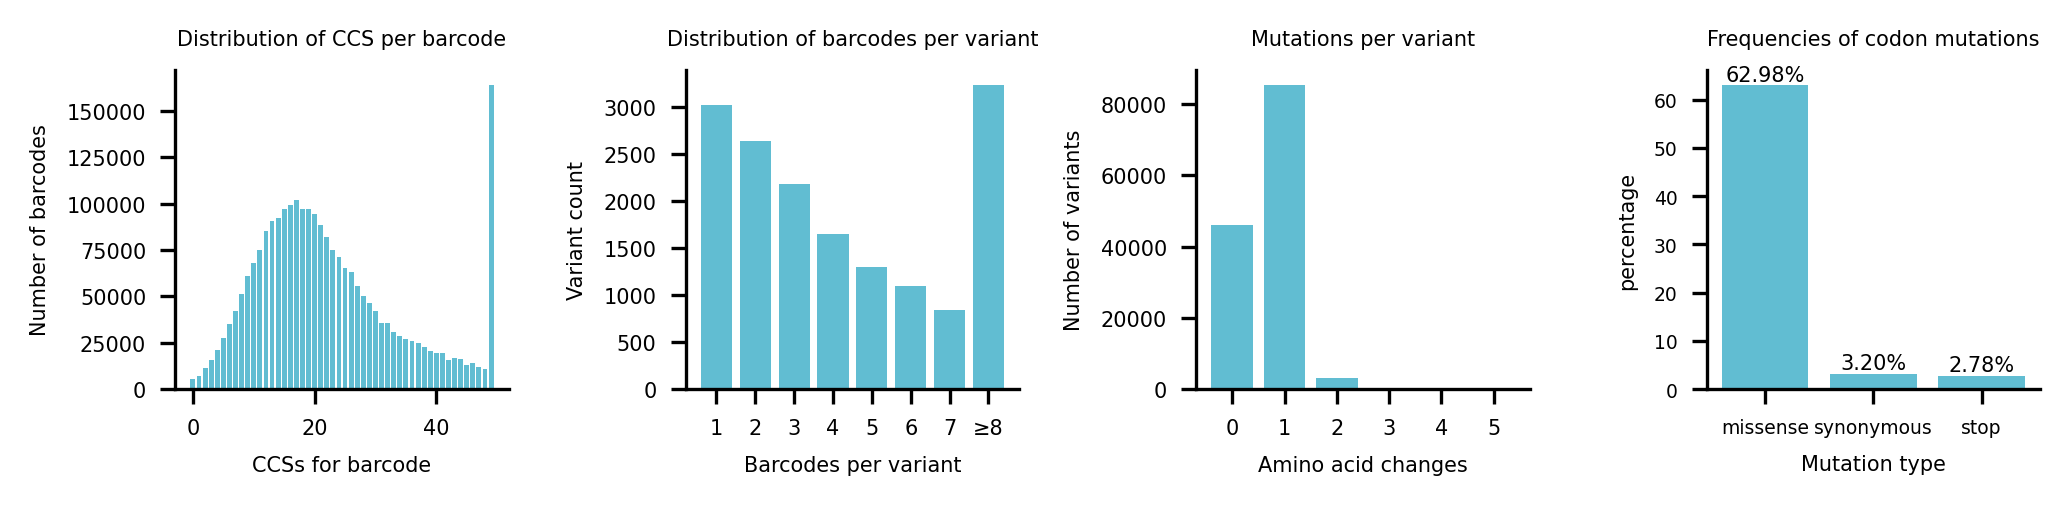

In [39]:
from collections import Counter

plt.figure(figsize=(7, 4.5), dpi=300)
plt.subplots_adjust(hspace=0.15, wspace=0.15)

ax = plt.subplot(3,4,1)


# Filter rows where 'retained' is True
filtered_data = processed_ccs.query('retained')

# Assign a column 'barcode_counts' with a value of 1
filtered_data = filtered_data.assign(barcode_counts=1)

# Group by 'library' and 'barcode', and count the occurrences
grouped_data = filtered_data.groupby(['library', 'barcode']).barcode_counts.transform('count')

# Clip the counts to the specified maximum value (max_count)
grouped_data = np.clip(grouped_data, None, max_count)

# Calculate the bar heights and positions
heights = grouped_data.value_counts().sort_index()
positions = np.arange(len(heights))




# Plot the barcode counts using ax.bar
ax.bar(positions, heights, width=0.8, color='#61BDD2')

# Set title and axis labels with font size
ax.set_title('Distribution of CCS per barcode', fontsize=5)
ax.set_xlabel('CCSs for barcodes', fontsize=5)
ax.set_ylabel('Number of barcodes', fontsize=5)
ax.tick_params(axis='both', labelsize=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
# Show the plot
#plt.show()

ax = plt.subplot(3,4,2)

df=variants.barcode_variant_df.copy()

df_singles_aa_substitutions = df[(df['number_of_indels']==0) & (df['n_aa_substitutions']==1)]

# Step 1: Group by 'aa_substitutions' and count the occurrences
grouped_counts = df_singles_aa_substitutions['aa_substitutions'].value_counts()

# Step 2: Cap the counts at 8 (i.e., group all counts >= 8 together)
grouped_counts_capped = grouped_counts.clip(upper=8)

# Step 3: Count how many substitutions occurred exactly 1 time, 2 times, etc.
heights = grouped_counts_capped.value_counts().sort_index()

# Positions for each bar on the x-axis
positions = np.arange(1, len(heights) + 1)  # Adjusted to match x-ticks from 1 to 8

# 
ax.bar(positions, heights, width=0.8, color='#61BDD2')

# Set font size for everything
font_size = 5
ax.set_xlabel('Barcodes per variant', fontsize=font_size)
ax.set_ylabel('Variant count', fontsize=font_size)
ax.set_title('Distribution of barcodes per variant', fontsize=font_size)

# Set font size for tick labels
ax.tick_params(axis='both', labelsize=font_size)

# Ensure all x-ticks from 1 to 8 are shown
ax.set_xticks(np.arange(1, 9))
ax.set_xticklabels([str(i) for i in range(1, 8)] + ['≥8'])

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()


ax = plt.subplot(3,4,3)

# Assuming variants.barcode_variant_df.n_aa_substitutions is a list of values
data = variants.barcode_variant_df.n_aa_substitutions

# Count occurrences of each unique value
value_counts = Counter(data)

# Extract values and their counts
values = list(value_counts.keys())
counts = list(value_counts.values())

# Create a bar plot
plt.bar(values, counts, color='#61BDD2')

# Customize the plot if needed
plt.xlabel('Amino acid changes', fontsize=font_size)
plt.ylabel('Number of variants', fontsize=font_size)
plt.title('Mutations per variant', fontsize=font_size)

# Set x-tick positions and labels
plt.xticks(values,  fontsize=5)
ax.tick_params(axis='both', labelsize=font_size)

# Remove the top and left spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

# Show the plot


ax = plt.subplot(3,4,4)

# Assuming variants.barcode_variant_df.variant_class is a list of values
data = variants.barcode_variant_df.variant_class

# Map '1 nonsynonymous' and '>1 nonsynonymous' to 'missense'
data_mapped = ['missense' if 'nonsynonymous' in item else item for item in data]

# Count occurrences of each unique value
value_counts = Counter(data_mapped)

# Extract values and their counts
values = list(value_counts.keys())[1:]
counts = list(value_counts.values())

# Calculate percentages
total_variants = sum(counts)
counts = counts[1:]
percentages = [count / total_variants * 100 for count in counts]

# Create a bar plot
bars = plt.bar(values, percentages, color='#61BDD2')

# Annotate the bars with percentages
for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=5)

# Customize the plot if needed
plt.xlabel('Mutation type', size=5)
plt.ylabel('percentage', size=5)
plt.title('Frequencies of codon mutations', size=5)

# Set x-tick positions and labels
plt.xticks(values, fontsize=5)
ax.tick_params(axis='both', labelsize=4.5)

# Remove the top and left spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

plt.savefig(f"{config['figs_dir']}/SuppFig1BCDE.pdf")
plt.show()

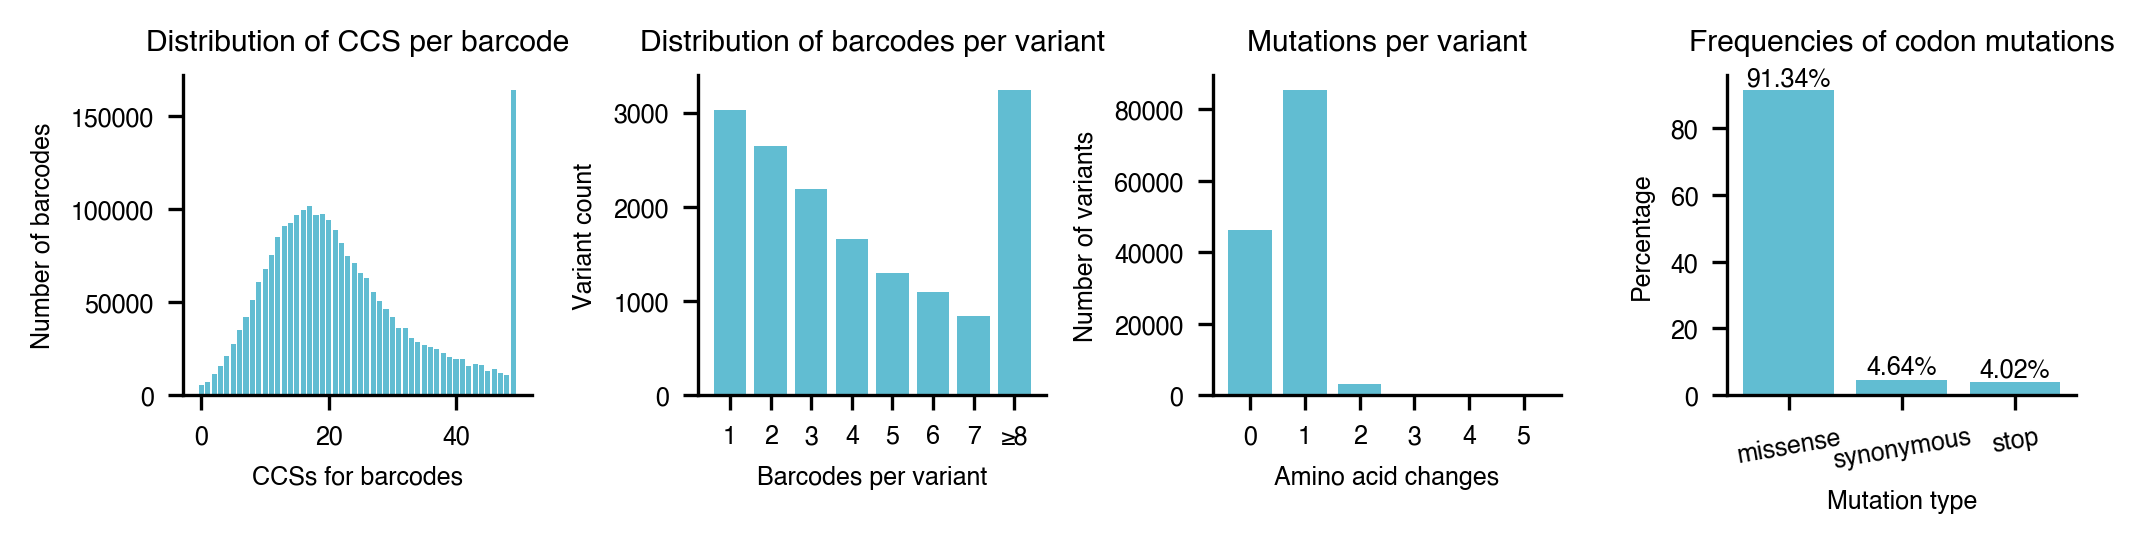

In [46]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

with matplotlib.rc_context({
    'font.family': 'Helvetica',
    'font.size': 6
}):
    plt.figure(figsize=(7, 4.5), dpi=300)
    plt.subplots_adjust(hspace=0.15, wspace=0.15)

    ax = plt.subplot(3, 4, 1)

    filtered_data = processed_ccs.query('retained')
    filtered_data = filtered_data.assign(barcode_counts=1)
    grouped_data = filtered_data.groupby(['library', 'barcode']).barcode_counts.transform('count')
    grouped_data = np.clip(grouped_data, None, max_count)
    heights = grouped_data.value_counts().sort_index()
    positions = np.arange(len(heights))

    ax.bar(positions, heights, width=0.8, color='#61BDD2')
    ax.set_title('Distribution of CCS per barcode')
    ax.set_xlabel('CCSs for barcodes')
    ax.set_ylabel('Number of barcodes')
    ax.tick_params(axis='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()

    ax = plt.subplot(3, 4, 2)

    df = variants.barcode_variant_df.copy()
    df_singles_aa_substitutions = df[(df['number_of_indels'] == 0) & (df['n_aa_substitutions'] == 1)]
    grouped_counts = df_singles_aa_substitutions['aa_substitutions'].value_counts()
    grouped_counts_capped = grouped_counts.clip(upper=8)
    heights = grouped_counts_capped.value_counts().sort_index()
    positions = np.arange(1, len(heights) + 1)

    ax.bar(positions, heights, width=0.8, color='#61BDD2')
    ax.set_xlabel('Barcodes per variant')
    ax.set_ylabel('Variant count')
    ax.set_title('Distribution of barcodes per variant')
    ax.tick_params(axis='both')
    ax.set_xticks(np.arange(1, 9))
    ax.set_xticklabels([str(i) for i in range(1, 8)] + ['≥8'])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()

    ax = plt.subplot(3, 4, 3)

    data = variants.barcode_variant_df.n_aa_substitutions
    value_counts = Counter(data)
    values = list(value_counts.keys())
    counts = list(value_counts.values())

    ax.bar(values, counts, color='#61BDD2')
    ax.set_xlabel('Amino acid changes')
    ax.set_ylabel('Number of variants')
    ax.set_title('Mutations per variant')
    ax.set_xticks(values)
    ax.tick_params(axis='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()

    ax = plt.subplot(3, 4, 4)

    data = variants.barcode_variant_df.variant_class
    data_mapped = ['missense' if 'nonsynonymous' in item else item for item in data]
    value_counts = Counter(data_mapped)
    values = list(value_counts.keys())[1:]
    counts = list(value_counts.values())[1:]
    total_variants = sum(counts)
    percentages = [count / total_variants * 100 for count in counts]

    bars = ax.bar(values, percentages, color='#61BDD2')
    for bar, percentage in zip(bars, percentages):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
                f'{percentage:.2f}%', ha='center', va='bottom', fontsize=6)

    ax.set_xlabel('Mutation type')
    ax.set_ylabel('Percentage')
    ax.set_title('Frequencies of codon mutations')
    ax.set_xticks(np.arange(len(values)))
    ax.set_xticklabels(values, rotation=10)
    ax.tick_params(axis='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()

    plt.savefig(f"{config['figs_dir']}/SuppFig1BCDE.pdf")
    plt.show()

In [49]:
print ("number of missense single aa substitutions linked with only one barcode:")
print(len([i for i in grouped_counts.values if i == 1]))

print ("number of missense single aa substitutions linked with two or more barcodes:")
print(len([i for i in grouped_counts.values if i > 1]))

number of missense single aa substitutions linked with only one barcode:
3031
number of missense single aa substitutions linked with two or more barcodes:
12965


## Completeness of mutation sampling

Examine how completely amino-acid mutations are sampled by the variants, looking at single-mutant variants only and all variants. The plot below shows that virtually every mutation is found in the library.

Saving plot to results/figures/variant_cumul_all_mut_coverage.pdf
Saving plot to results/figures/variant_cumul_single_mut_coverage.pdf


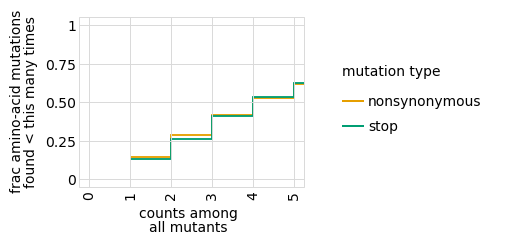

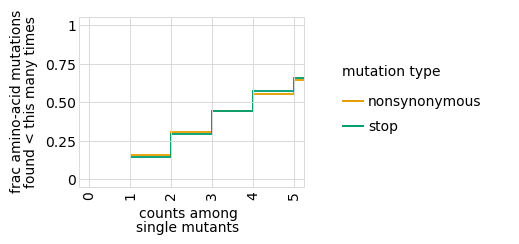

In [50]:
for variant_type in ['all', 'single']:
    p = variants.plotCumulMutCoverage(variant_type, mut_type='aa', samples=None)
    _ = p.draw()
    plotfile = os.path.join(config['figs_dir'],
                            f"variant_cumul_{variant_type}_mut_coverage.pdf")
    print(f"Saving plot to {plotfile}")
    p.save(plotfile)

To get more quantitative view, determine how many mutations are found 0, 1, or >1 times both among single and all mutants for the primary target:

In [51]:
count_dfs = []
for variant_type in ['all', 'single']:
    i_counts = (variants.mutCounts(variant_type, mut_type='aa', samples=None)
                .assign(variant_type=variant_type)
                )
    count_dfs += [i_counts.assign(include_stops=True),
                  i_counts
                  .query('not mutation.str.contains("\*")', engine='python')
                  .assign(include_stops=False)
                  ]
    
display(HTML(
    pd.concat(count_dfs)
    .assign(count=lambda x: (numpy.clip(x['count'], None, 2)
                             .map({0: '0', 1: '1', 2:'>1'}))
            )
    .groupby(['variant_type', 'include_stops', 'library', 'count'])
    .aggregate(number_of_mutations=pd.NamedAgg(column='mutation', aggfunc='count'))
    .to_html()
    ))

## Mutation frequencies along gene

Plot the frequencies of mutations along the amplicon for both all variants and single-mutant / wildtype variants:

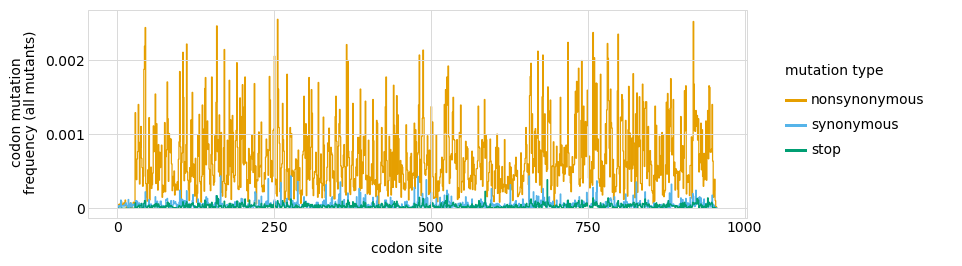


Saving plot to results/figures/variant_cumul_all_mut_Freqs.pdf


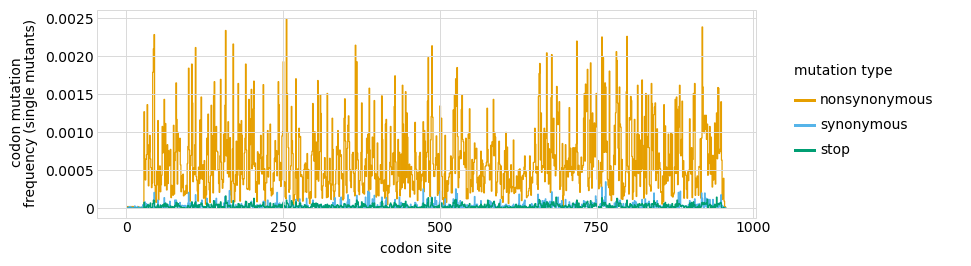


Saving plot to results/figures/variant_cumul_single_mut_Freqs.pdf


In [52]:
for variant_type in ['all', 'single']:
    p = variants.plotMutFreqs(variant_type, mut_type='codon', samples=None
                              , heightscale=1.5, widthscale=2.5)
    print(p)
    plotfile = os.path.join(config['figs_dir'],
                            f"variant_cumul_{variant_type}_mut_Freqs.pdf")
    print(f"Saving plot to {plotfile}")
    p.save(plotfile)

Using heat maps to examine the extent to which specific amino-acid or codon mutations are over-represented:

Saving plot to results/figures/variant_cumul_single_mut_heatmap.pdf
Saving plot to results/figures/variant_cumul_single_mut_heatmap.pdf


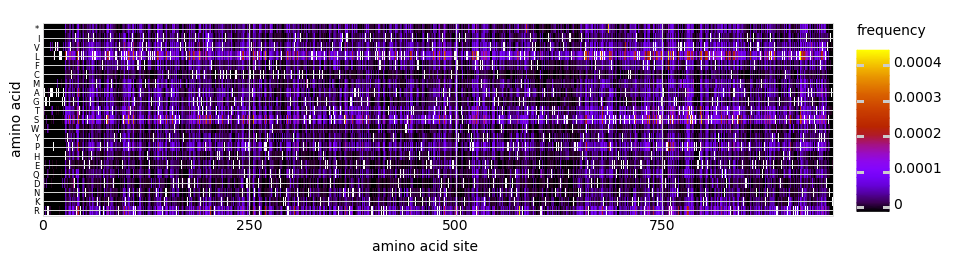

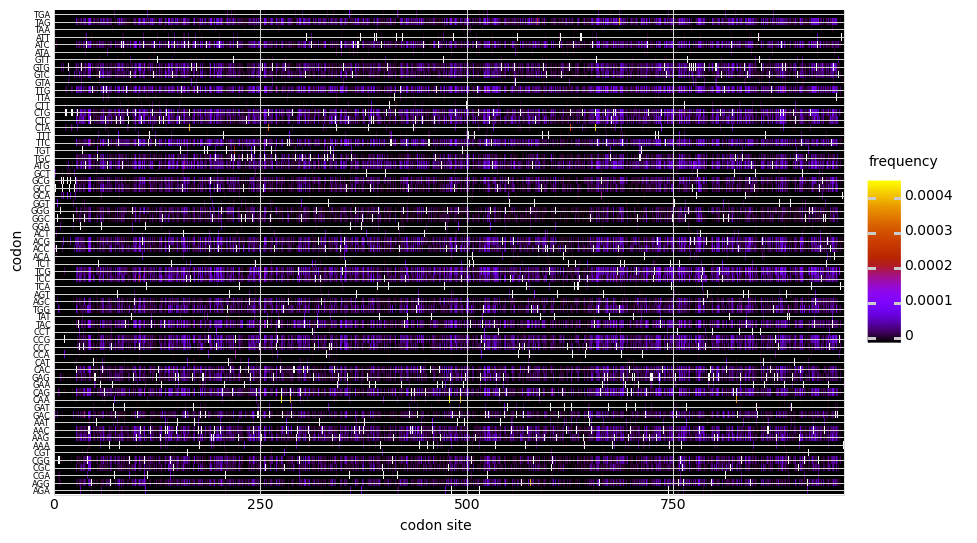

In [53]:
for mut_type in ['aa', 'codon']:
    p = variants.plotMutHeatmap('all', mut_type, samples=None, #libraries='all_only',
                                widthscale=2)
    p.draw()
    
    plotfile = os.path.join(config['figs_dir'],
                            f"variant_cumul_{variant_type}_mut_heatmap.pdf")
    print(f"Saving plot to {plotfile}")
    p.save(plotfile)

## Drop variants with indels

In [54]:
print (f" {len(variants.barcode_variant_df.query('number_of_indels>0'))}  variants with indels dropped from codon-variant table")

variants.barcode_variant_df = variants.barcode_variant_df.query('number_of_indels==0').reset_index(drop=True)

 5585  variants with indels dropped from codon-variant table


## Drop variants n_aa_substitutions more than 1 (multi variants)

In [55]:
print (f" {len(variants.barcode_variant_df .query('n_aa_substitutions>1'))}  variants with more than one substitutions dropped from codon-variant table")

variants.barcode_variant_df = variants.barcode_variant_df.query('n_aa_substitutions<2').reset_index(drop=True)

 2988  variants with more than one substitutions dropped from codon-variant table


## Reverse complement the barcode sequences
Barcodes sequenced in reverse complement direction in Flow-Seq, therefore, need to reverse complement the barcodes to Flow-Seq variant count


In [56]:
def reverse_complement(sequence):
    complements = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    sequence = sequence[::-1]
    return sequence.translate(sequence.maketrans(complements))

variants.barcode_variant_df["barcode"] = (variants.barcode_variant_df["barcode"]
                                           .apply(reverse_complement))

## Write codon-variant table
The codon-variant table looks like this:

In [57]:
display(HTML(
    variants.barcode_variant_df
    .head()
    .to_html(index=False)
    ))

target,library,barcode,variant_call_support,number_of_indels,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions,variant_class,aa_substitutions_c
INSR_PacBio_amplicon,insr,AATGGCGAATTATCTACAGCCATTTTTTTT,5,0,,,0,0,wildtype,wildtype
INSR_PacBio_amplicon,insr,ATCAAACAAAGCACCGATCACATTTTTTTT,9,0,GAA938GCC,E938A,1,1,1 nonsynonymous,E938A
INSR_PacBio_amplicon,insr,GACAAGAAGCACTTGGTTAAATGTTTTTTT,19,0,,,0,0,wildtype,wildtype
INSR_PacBio_amplicon,insr,GGGGGAGCTGAGGCGCCTAGTAATTTTTTT,1,0,TCC711TCG,,1,0,synonymous,synonymous
INSR_PacBio_amplicon,insr,GACTTGGAAAAACTCAGTTGATCGTTTTTT,31,0,AAG337CTC,K337L,1,1,1 nonsynonymous,K337L


In [58]:
print(f"Writing codon-variant table with reverse complemented barcodes to {config['codon_variant_table_file_bcRevCom']}")

variants.barcode_variant_df.to_csv(config['codon_variant_table_file_bcRevCom'], index=False)

Writing codon-variant table with reverse complemented barcodes to results/variants/codon_variant_table.csv


## Write full lengeth gene sequence for variants, this will be used as input for Enrich2

In [59]:
df_seq = variants.add_full_seqs(variants.barcode_variant_df)
df_seq.columns = [*df_seq.columns[:-1], 'variant']

print(f"Writing codon-variant table with full length gene sequences needed for Enrich2 input to {config['codon_variant_table_forEnrich2']}")

df_seq[['barcode','variant']].to_csv(config['codon_variant_table_forEnrich2'], sep ='\t', index=False, header=False)

Writing codon-variant table with full length gene sequences needed for Enrich2 input to results/variants/barcode_variant_enrich2.tab


### continue to flowSeq_analysis.ipynb for further analysis